# Observational Causal Inference Simulation : Using Matching Methods for Cross-Sectional Studies with Binary Treatment

*If you see any errors (or suggestions) below, feel free to let me know!*

## Table of Contents



- Introduction
- An industry example
- A quick note on identifying potential causal analyses
- Load libraries
- Simulate the data
- Apply Matching
- Check Balance
- Compute Causal Treatment Effect
- Final Notes (what this notebook skipped over)

## Introduction

Matching is a popular causal inference method used for (most conventionally) pre-processing your data to balance your covariates (therefore controlling for confounding) as well as reducing model dependence, so that upon matching, a simple difference in means should suffice to compute the causal treatment effect estimate ([Ho et al., 2007](https://gking.harvard.edu/files/matchp.pdf)). As explained in the [MatchIt vignette](https://cran.r-project.org/web/packages/MatchIt/vignettes/MatchIt.html) by Noah Greifer, arguably the best practical R guide on Matching, current best practices involve applying g-computation (a parametric modeling method) to your matched data to control for any remaining imbalance. Because matching reduces model dependence, the parametric method you use post-matching is more reliable and trustable. You can read about model dependence in ([King and Zeng, 2006](https://gking.harvard.edu/files/counterft.pdf)).

The most popular form of using matching methods is on cross-sectional data (each user is exposed to one treatment just once in a single point in time) with a binary treatment and binary or continuous outcome (Matching is not limited to these specifications, and appears to be a relatively flexible method). Cross-sectional data is the class of studies that I've encountered the most often at work, and so for the simulation below we will focus on this type of data.

## An industry example

A clear example of a causal question with this kind of specification, from [LinkedIn's Data Science team](https://hdsr.mitpress.mit.edu/pub/wjhth9tr/release/3), is analyzing the causal effect of a job posting having a job title versus not on the outcome, "view-to-apply rate". Intuitively, one could imagine a scenario where users may apply more to job postings with a clear job title than a more generic one due to the increased certainty in what the posting asks for. In their scenario, they saw a naive difference of a +10% effect. However, because the treatment is not random (because it's not an A/B test), there is the risk of confounding. For instance, it could be that more prestigious companies have higher view-to-apply to begin with, and it could also be true at the same time that more prestigious companies are more clear with their job postings. They controlled for hundreds of covariates in a 16million row dataset and ended with a causal effect estimate of 2.4%, which is a 74% reduction from the naive estimate.

In addition, they performed similar analyses on other attributes of a job posting as well, and used these findings to recommend the product team on how to improve the UI and what changes they could make to increase the experience for their customers.

## A quick note on identifying potential causal analyses

Personally speaking, I've found that one of the more difficult aspects of these studies in the industry is causal question discovery, or in other words, finding correct questions to apply causal analyses on.

Of-course, this depends on a variety of factors, including the data availability in your product function, stakeholder / leadership buy-in for observational causal inference, as well as other important considerations.

For example, whenever possible, A/B testing should be the go-to method for making causal claims as it doesn't require the same frustrating untestable assumptions that exist in observational studies. If A/B testing is not possible, one can consider observational studies, but at the same time, the treatment must be actionable - if you find a positive/negative/neutral result, what can be done with it? If your proposed treatment is something that the product team (or any team in the company) have no control over, then other causal questions might be better to prioritize. Of-course, at the end of the day, this all depends on the vision and goals of your product and data science organization, so there certainly may be times where these analyses are valuable, even if not easily actionable.

Another consideration is the data. Your product function may possess rich datasets like in the example above where the Data Scientist had 16 million rows to work with, but this won't always be the case, and your results will lack precision (i.e., wider confidence intervals). In addition, if too many of the hypothesized confounders aren't actually measurable given the current tracking system in your company, then it will take more work for your results to be convincing.

All-in-all, given all these considerations, the best thing you can do as an analyst is to be transparent and communicate these nuances effectively, on top of making the best (possible) strategic decisions.

## Load Libraries

In [1]:
# all Python libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load R
# Guide here: https://colab.research.google.com/drive/1ISG891i076enSPB-4bni_DECWlFlnasU?usp=sharing
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [4]:
%%R
#install.packages("MatchIt") # main matching package
#install.packages("cobalt") # balance diagnostics
#install.packages("quickmatch") # to allow generalized full matching on MatchIt()
#install.packages("marginaleffects") # to compute treatment effect

NULL


In [6]:
%%R
library("MatchIt")
library("cobalt")
library("marginaleffects")

In [7]:
# Change plot settings
# Guide here: https://colab.research.google.com/drive/1wqIUyStkKbUc4MYPvJgIExPOFvC5cUs2?usp=sharing
plt.rcParams['figure.figsize'] = (3, 3)

## Simulate the data

Let's simulate some data, using a similar data generation process from ([Iacus, King, and Porro, 2011](https://gking.harvard.edu/sites/scholar.harvard.edu/files/gking/files/political_analysis-2011-iacus-pan_mpr013.pdf)). To keep it simple, we'll have 2 confounders - one binary (categorical) and one non-categorical. We will use a binary treatment setup and a continuous outcome.

We'll define the following covariates:
- $\text{age}\sim\text{Poisson}(40)$
- $\text{gender}\sim\text{Bernoulli}(0.5)$

And the treatment:
- $\text{Treatment}\sim|(\text{Bernoulli}(\text{logit}\{\frac{1}{40}\times\text{age}-0.5\times\text{gender}\})-1)|$

And outcome:
- $\text{Outcome}=-1\times\text{Treatment}-4\times\text{age}-4\times\text{gender}+\epsilon$

where:
- $\epsilon\sim\text{Normal}(0,1)$

This way, our covariates influence both the Treatment and the Outcome.

In [27]:
# sample size
n = 30000

# define covariates
w1 = np.random.poisson(40,n)
w2 = np.random.binomial(1,0.5,n)
w2_cat = np.where(w2==1,'Male','Female')

# treatment
a = np.where(np.random.binomial(1,expit((1/40)*w1-.5*w2),n)==1,0,1)

# outcome
e = np.random.normal(0,1,n)
y = -a-4*w1-4*w2+e

# put into a pandas dataframe
d = {'y':y, 'a':a, 'age':w1, 'gender':w2_cat}
df = pd.DataFrame(data=d)

We see below that when computing the simple difference in means:
$$E[Y|A=1] - E[Y|A=0]$$

Our coefficient for $\hat{A}\approx 2.\#$, when our true effect is $A=-1$. This is deadily because the true effect is negative, as in the Treatment negatively affects the outcome, but without applying causal methods, we are left with a positive treatment effect.

In [28]:
%%R -i df

print(avg_comparisons(lm(y~a,df), variables = "a"))


 Term Contrast Estimate Std. Error    z Pr(>|z|)    S 2.5 % 97.5 %
    a    1 - 0     2.51      0.313 8.01   <0.001 49.6  1.89   3.12

Columns: term, contrast, estimate, std.error, statistic, p.value, s.value, conf.low, conf.high 
Type:  response 



## Apply Matching

Now, we'll apply matching using the `MatchIt()` package in R. I've looked around but there really is no better guide for this than the following vignettes by Noah Greifer:
- https://cran.r-project.org/web/packages/MatchIt/vignettes/MatchIt.html
- https://cran.r-project.org/web/packages/MatchIt/vignettes/matching-methods.html
- https://cran.r-project.org/web/packages/MatchIt/vignettes/assessing-balance.html
- https://cran.r-project.org/web/packages/MatchIt/vignettes/estimating-effects.html

One reason is that he provides further readings for almost every topic. A lot of the papers I've read on matching were recommended by him.

Below, we actually try two different matching specifications, one called Generalized Full Matching and one called Coarsened Exact Matching.

You can find a quick overview of matching methods at ([Greifer and Stuart, 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9005055/)).

The `method` parameter is where you specify the method. The `distance` parameter is choosing what distance metric you will use, for matching methods that use a distance measure (For example, in nearest neighbor matching, you match treatment units to units that are closest in control units, and you measure "closeness" using the distance measure).

I've used mahalanobis distance due to increased hesitancy for using propensity scores (for the purpose of matching). Here is a famous paper about it ([King and Nielsen, 2019](https://gking.harvard.edu/sites/scholar.harvard.edu/files/gking/files/pan1900011_rev.pdf)). I thought that the paper is very friendly, but here's a lecture version by Gary King: [YouTube Link](https://www.youtube.com/watch?v=rBv39pK1iEs). Noah has a good review of the paper as well on [CrossValidated](https://stats.stackexchange.com/questions/481110/propensity-score-matching-what-is-the-problem). On the topic of Gary King, here is another fun lecture where he discusses Matching methods from 3 years ago: [YouTube Link](https://www.youtube.com/watch?v=tvMyjDi4dyg). He heavily advocates for Coarsened Exact Matching or Mahalanobis matching and discusses the Matching Frontier, which he explains is the next step in matching methods advancement. Coarsened Exact Matching can be read about in ([Iacus, King, and Porro, 2011](https://gking.harvard.edu/sites/scholar.harvard.edu/files/gking/files/political_analysis-2011-iacus-pan_mpr013.pdf)). To put it simply, CEM tries to capitalize on the benefits of exact matching while trying to avoid the curse of dimensionality. Here's some criticism though for CEM by [Noah Greifer](https://stats.stackexchange.com/questions/462606/is-coarsened-exact-matching-superior-to-other-matching-methods-in-case-control-s) as well as from a paper that I've (admittedly) only glanced at, ([Black, Lalkiya, and Lerner, 2022](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3694749)).

Remember that there is a "no free lunch" theorem too in matching methods, so there's no single method that beats all methods in every situation for every metric you're trying to optimize for. Therefore, all of these methods can be the best for different problems, and their performance can be viewed using the recommended balance assessment methods. So as an example, even though propensity score matching is criticized, if you've shown that in your dataset that it balanced well, effective sample size is good, and your estimand is what you were looking for (and other convincing considerations were made and communicated, and your audience is satisfied), then it's fine.

In addition, there are a *lot* of other things you can specify in the matchit algorithm, and I've only included the basics below, so it would be good to look in the vignettes and the recommended readings.

In [46]:
%%R -i df
# quick matching (generalized full matching)
m.out2 <- matchit(a ~ age + gender, data = df,
                 method = "quick", distance = "robust_mahalanobis",estimand='ATE')

# coarsened exact matching
m.out3 <- matchit(a ~ age + gender, data = df,
                 method = "cem",estimand='ATE')

Note that while I've put `estimand='ATE'`, not all matching methods that allow that estimand actually guarantee that it will provide the ATE, depending on what kind of samples were dropped. Whether or not you are looking for the ATT, ATC, ATE, or if generalizability isn't the biggest concern, this will impact which matching specification is available for you.

Below, we can check the balance performance using the `cobalt` package.

## Check Balance

In [31]:
%%R
# Check balance before and after matching
cobalt::bal.tab(a ~ age + gender, data = df,
        un = TRUE, weights = list(qk = m.out2, cem = m.out3),s.d.denom='pooled')

Balance Measures
               Type Diff.Un Diff.qk Diff.cem
age         Contin. -0.1598 -0.0002  -0.0027
gender_Male  Binary  0.1327  0.0000   0.0000

Effective sample sizes
     Control Treated
All 20214.   9786.  
qk  19962.65 9228.33
cem 19991.35 9322.98


We can also see some of the above information in graphical form, which I think is easier on the eyes. The 0.1 treshold is the recommended benchmark in the literature. So, if your covariates are above 0.1 in imbalance, then it would be good to continue trying different specifications. You can read more about these balance diagnostics in ([Austin, 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/#s11title)). We use "standardized" mean differences so that we can somewhat compare them across covariates.

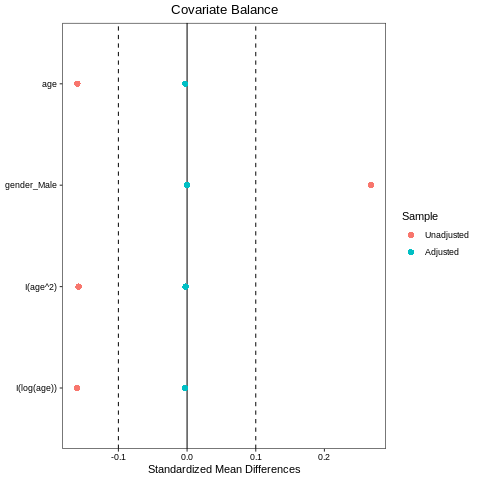

In [39]:
%%R
cobalt::love.plot(m.out3,binary = "std",
                  drop.distance = FALSE,
                  thresholds = c(m = .1),
                  addl = ~I(age^2)+I(log(age)))

We can also see how each variable matched. There's a ton of other diagnostic charts we can check, and I again encourage the [vignette](https://cran.r-project.org/web/packages/MatchIt/vignettes/assessing-balance.html).

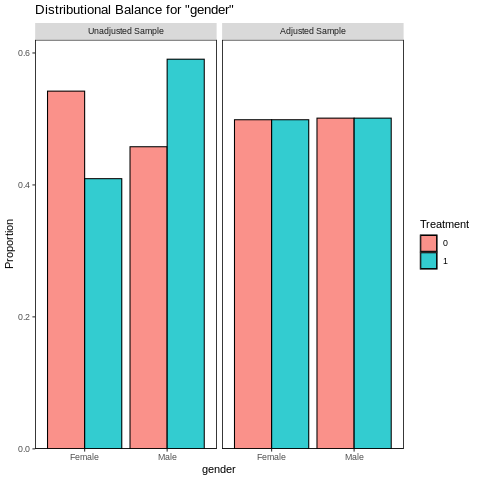

In [41]:
%%R
#Density plot for continuous variables
cobalt::bal.plot(m.out3, var.name = "gender", which = "both")

Then, we can use the matched data to compute the treatment effect.

## Compute Causal Treatment Effect

In [42]:
%%R
m.data <- match.data(m.out3)

In [44]:
%%R
fit <- lm(y ~ a * (age + gender), data = m.data, weights = weights)

avg_comparisons(fit,
                variables = "a",
                vcov = "HC3",
                wts = "weights")


 Term Contrast Estimate Std. Error     z Pr(>|z|)   S 2.5 % 97.5 %
    a    1 - 0       -1     0.0126 -79.7   <0.001 Inf -1.03 -0.978

Columns: term, contrast, estimate, std.error, statistic, p.value, s.value, conf.low, conf.high 
Type:  response 



Note that we include format the `lm()` function as `a * (age + gender)` as recommended, but it isn't strictly necessary (it only helps), and as matching should have reduced model dependence, we can do a simple (weighted) difference in means below and the results should be roughly the same:

In [45]:
%%R
fit <- lm(y ~ a, data = m.data, weights = weights)

avg_comparisons(fit,
                variables = "a",
                vcov = "HC3",
                wts = "weights")


 Term Contrast Estimate Std. Error     z Pr(>|z|)   S 2.5 % 97.5 %
    a    1 - 0   -0.935      0.326 -2.87   0.0041 7.9 -1.57 -0.297

Columns: term, contrast, estimate, std.error, statistic, p.value, s.value, conf.low, conf.high 
Type:  response 



Note here that the results are almost the same. You'll notice that the confidence intervals are wider though, which is I believe one reason that we we include those interactions. (I'm not super confident about this reasoning/result though, but I have heard that we include the interactions with the covariates to retain the target estimand and ensure valid inference).

## Final notes (what this notebook skipped over)

You'll notice that in our discussion above, we mostly skipped over the topic that makes observational causal inference so difficult - untestable assumptions. This isn't limited to confounder-control studies like Matching and is true for all causal inference methods. Judea Pearl says that we as practitioners need to "cope with untestable assumptions" ([Pearl, 2009](https://ftp.cs.ucla.edu/pub/stat_ser/r350.pdf)), and he has discussed extensively on why observational causal inference is valuable. We also skipped over confounder selection. These will be covered in a different notebook!
